In [1]:
#import libraries and functions of interest
import scipy as sp
import numpy as np
import pandas as pd
import cobra as cb
import sklearn as skl
import lightgbm as lgb
import matplotlib.pyplot as plt

In [2]:
#import model (.xml file type)

#IMPORTANT: Before importing the metabolic model, edit all c0->c and e0->e, the current file is edited as such but any other file would need to be adjusted

filename = r"RAST_P_luminescens_Metabolic_Model_Prokaryotic.gf.xml"
model = cb.io.sbml.read_sbml_model(filename)
raw_model = cb.io.sbml.read_sbml_model(filename)

#get the currect objective rxn
obj_rxn = cb.util.solver.linear_reaction_coefficients(model)

#find original solution and summary
initial_solution = model.optimize()
raw_solution = raw_model.optimize()
print("Original Solution:", initial_solution)

#get the summary for the model
initial = model.summary()

#print the counts of original reactions
print("Number of Reactions:", len(model.reactions))
print("Number of Metabolites:", len(model.metabolites))
print("Number of Genes:", len(model.genes))
print("Objective Reaction:", obj_rxn)
#report initial summary
initial

Original Solution: <Solution 91.897 at 0x27f59b0df90>
Number of Reactions: 1535
Number of Metabolites: 1354
Number of Genes: 1029
Objective Reaction: {<Reaction bio1_biomass at 0x27f579c2020>: 1.0}


Metabolite,Reaction,Flux,C-Number,C-Flux
cpd00007_e,EX_cpd00007_e,265.9,0,0.00%
cpd00023_e,EX_cpd00023_e,64.35,5,1.75%
cpd00030_e,EX_cpd00030_e,0.147,0,0.00%
cpd00033_e,EX_cpd00033_e,79.11,2,0.86%
cpd00034_e,EX_cpd00034_e,0.147,0,0.00%
cpd00039_e,EX_cpd00039_e,25.32,6,0.83%
cpd00051_e,EX_cpd00051_e,21.88,6,0.71%
cpd00054_e,EX_cpd00054_e,33.29,3,0.54%
cpd00058_e,EX_cpd00058_e,0.147,0,0.00%
cpd00060_e,EX_cpd00060_e,12.51,5,0.34%


In [3]:
#import the needed functions to add my own reactions and metabolites
from cobra import Reaction, Metabolite

#add positive fluxes
#find metabolites of interest for my reaction(s)
FMNH2_c = model.metabolites.get_by_id('cpd01270_c')
FMN_c = model.metabolites.get_by_id('cpd00050_c')
propanal_c = model.metabolites.get_by_id('cpd00371_c')
O2_c = model.metabolites.get_by_id('cpd00007_c')
propioante_c = model.metabolites.get_by_id('cpd00141_c')
H2O_c = model.metabolites.get_by_id('cpd00001_c')
H_c = model.metabolites.get_by_id('cpd00067_c')
#create a light metabolites
light = Metabolite(
    'light',
    formula='γ',
    name='Light',
    compartment='c')

In [4]:
#create exchange reaction to add propioante
EX_propioante = Reaction('EX_propioante_c')
EX_propioante.name = 'Exchange Reaction for propioante'
EX_propioante.subsystem = 'Non Metabolic Reaction, Exchange Reaction'
EX_propioante.lower_bound = -10.  # This is the default
EX_propioante.upper_bound = 1000

EX_propioante.add_metabolites({
    propioante_c: -1.0    
})

#create exchange reaction to add FMN
EX_FMN = Reaction('EX_FMN_c')
EX_FMN.name = 'Exchange Reaction for FMN'
EX_FMN.subsystem = 'Non Metabolic Reaction, Exchange Reaction'
EX_FMN.lower_bound = -10.  # This is the default
EX_FMN.upper_bound = 1000

EX_FMN.add_metabolites({
    FMN_c: -1.0    
})
#create exchange reaction to add FMN
EX_light = Reaction('EX_light')
EX_light.name = 'Exchange Reaction for light'
EX_light.subsystem = 'Non Metabolic Reaction, Exchange Reaction'
EX_light.lower_bound = -10.  # This is the default
EX_light.upper_bound = 1000

EX_light.add_metabolites({
    light: -1.0    
})

model.add_reactions([EX_propioante])
model.add_reactions([EX_FMN])
model.add_reactions([EX_light])

In [5]:
#create exchange reaction to add propanal
EX_propanal = Reaction('EX_propanal_c')
EX_propanal.name = 'Exchange Reaction for Propanal'
EX_propanal.subsystem = 'Non Metabolic Reaction, Exchange Reaction'
EX_propanal.lower_bound = 0.  # This is the default
EX_propanal.upper_bound = 1000
EX_propanal.add_boundary = 'exchange'

EX_propanal.add_metabolites({
    propanal_c: 1.0    
})

#create exchange reaction to add FMNH2
EX_FMNH2 = Reaction('EX_FMNH2_c')
EX_FMNH2.name = 'Exchange Reaction for Propanal'
EX_FMNH2.subsystem = 'Non Metabolic Reaction, Exchange Reaction'
EX_FMNH2.lower_bound = 0.  # This is the default
EX_FMNH2.upper_bound = 1000
EX_FMNH2.add_boundary = 'exchange'

EX_FMNH2.add_metabolites({
    FMNH2_c: 1.0    
})

model.add_reactions([EX_propanal])
model.add_reactions([EX_FMNH2])

print("Number of Reactions with exchange:", len(model.reactions))
print("Number of Metabolites with exchange:", len(model.metabolites))
print("Number of Genes with exchange:", len(model.genes))

Number of Reactions with exchange: 1540
Number of Metabolites with exchange: 1355
Number of Genes with exchange: 1029


In [6]:
#verify changes by checking the exhcange reaction for propanal
model.reactions.get_by_id("EX_propanal_c")

Reaction identifier,EX_propanal_c
Name,Exchange Reaction for Propanal
Memory address,0x27f59f77e80
Stoichiometry,--> cpd00371_c --> Propanal [c]
GPR,
Lower bound,0.0
Upper bound,1000


In [7]:
#create reaction of interest
reaction = Reaction('luciferase')
reaction.name = 'Luciferase '
reaction.subsystem = 'Non Metabolic Reaction, Bioluminescence'
reaction.lower_bound = 0.  # This is the default
reaction.upper_bound = 1000.  # This is the default
reaction.add_boundary = 'demand'

#create the stiochiometry for the rxn of interest
reaction.add_metabolites({
    FMNH2_c: -1.0,
    FMN_c: 1.0,
    propanal_c: -1.0,
    O2_c: -1.0,
    propioante_c: 1.0,
    H2O_c: 1.0,
    light: 1.0,
    H_c: 2.0,
    
})

#add genes associated with the production of luciferase
reaction.gene_reaction_rule = 'KS18_RS20720 and KS18_RS20725 and KS18_RS20710 and KS18_RS20715 and KS18_RS20730'

#add reaction to model
model.add_reactions([reaction])

#attempt solution after addition of rxn of interest
solution = model.optimize()
print("New Solution:", solution)

#verify reaction addition to model
print("Number of Reactions with luciferase:", len(model.reactions))
print("Number of Metabolites with luciferase:", len(model.metabolites))
print("Number of Genes with luciferase:", len(model.genes))
reaction.reaction

New Solution: <Solution 91.924 at 0x27f59facf10>
Number of Reactions with luciferase: 1541
Number of Metabolites with luciferase: 1355
Number of Genes with luciferase: 1034


'cpd00007_c + cpd00371_c + cpd01270_c --> cpd00001_c + cpd00050_c + 2.0 cpd00067_c + cpd00141_c + light'

In [8]:
#verify the luciferase reaction was added to the model
luciferase = model.reactions.get_by_id("luciferase")
#check bounds, flux, mass balance of reaction, and flux expression
print(luciferase.flux)
print(luciferase.check_mass_balance())
print(model.reactions.luciferase.flux_expression)
luciferase

0.0
{}
1.0*luciferase - 1.0*luciferase_reverse_c4e3e


Reaction identifier,luciferase
Name,Luciferase
Memory address,0x27f4f9e9cc0
Stoichiometry,cpd00007_c + cpd00371_c + cpd01270_c --> cpd00001_c + cpd00050_c + 2.0 cpd00067_c + cpd00141_c + light O2 [c] + Propanal [c] + FMNH2 [c] --> H2O [c] + FMN [c] + 2.0 H+ [c] + Propionate [c] + Light
GPR,KS18_RS20720 and KS18_RS20725 and KS18_RS20710 and KS18_RS20715 and KS18_RS20730
Lower bound,0.0
Upper bound,1000.0


In [9]:
#pulling information for the protein synthesis in order to link the flux of this reaction with the flux of luciferase
var = model.reactions.get_by_id('rxn05296_c')
var

Reaction identifier,rxn05296_c
Name,Protein synthesis
Memory address,0x27f5712e7d0
Stoichiometry,27.684983832597 cpd00001_c + 35.5949792133389 cpd00002_c + 0.388588889398408 cpd00023_c + 0.904337964148734 cpd00033_c + 0.759012038032257 cpd00035_c + 0.506271296960121 cpd00039_c +... 27.684983832597 H2O [c] + 35.5949792133389 ATP [c] + 0.388588889398408 L-Glutamate [c] + 0.904337964148734 Glycine [c] + 0.759012038032257 L-Alanine [c] + 0.506271296960121 L-Lysine [c] +...
GPR,KS18_RS04420 and KS18_RS00805 and KS18_RS20205 and KS18_RS22925 and KS18_RS18495 and KS18_RS22865...
Lower bound,0.0
Upper bound,1000.0


In [10]:
#link flux of luciferase with another reaction: I don't know why the -0 works but if its not there it breaks
same_flux = model.problem.Constraint(model.reactions.luciferase.flux_expression - model.reactions.rxn05296_c.flux_expression,
    lb=-0,
    ub=0)
model.add_cons_vars(same_flux)

In [14]:
#checking the solution
solution = model.optimize()
print('Flux of the protein syntesis reaction:',solution.fluxes['rxn05296_c'], '\nFlux of luciferase:',solution.fluxes['luciferase'],
      "\nFlux of the whole model:",solution.objective_value)

Flux of the protein syntesis reaction: 50.02185942345363 
Flux of luciferase: 50.02185942345362 
Flux of the whole model: 91.92379580711793


In [15]:
#check the summary of the updated metabolic model
results_summary = model.summary()
results_summary

Metabolite,Reaction,Flux,C-Number,C-Flux
cpd01270_c,EX_FMNH2_c,50.02,17,4.38%
cpd00007_e,EX_cpd00007_e,314,0,0.00%
cpd00023_e,EX_cpd00023_e,60.83,5,1.57%
cpd00027_e,EX_cpd00027_e,35.62,6,1.10%
cpd00030_e,EX_cpd00030_e,0.1471,0,0.00%
cpd00033_e,EX_cpd00033_e,79.13,2,0.82%
cpd00034_e,EX_cpd00034_e,0.1471,0,0.00%
cpd00039_e,EX_cpd00039_e,25.32,6,0.78%
cpd00051_e,EX_cpd00051_e,21.89,6,0.68%
cpd00054_e,EX_cpd00054_e,33.3,3,0.52%


In [16]:
#create a production envelope for both the untouched raw model and the updated metabolic model
prod_env = cb.flux_analysis.production_envelope(model, "EX_cpd00007_e", objective='bio1_biomass', points=20)
prod_env_raw = cb.flux_analysis.production_envelope(raw_model, "EX_cpd00007_e", objective='bio1_biomass', points=20)
#check the production envelope of the updated model
prod_env.head()

,carbon_source,flux_minimum,carbon_yield_minimum,mass_yield_minimum,flux_maximum,carbon_yield_maximum,mass_yield_maximum,EX_cpd00007_e
0,"EX_cpd00039_e, EX_cpd00066_e, EX_cpd00080_e, E...",0.0,3.435378e-15,NaN,91.923796,1.627544,NaN,-1000.000000
1,"EX_cpd00039_e, EX_cpd00066_e, EX_cpd00080_e, E...",0.0,5.044784e-14,NaN,91.923796,1.645772,NaN,-947.368421
2,"EX_cpd00039_e, EX_cpd00066_e, EX_cpd00080_e, E...",0.0,5.138099e-14,NaN,91.923796,1.666180,NaN,-894.736842
3,"EX_cpd00039_e, EX_cpd00066_e, EX_cpd00080_e, E...",0.0,5.266306e-14,NaN,91.923796,1.689380,NaN,-842.105263
4,"EX_cpd00039_e, EX_cpd00066_e, EX_cpd00080_e, E...",0.0,5.401076e-14,NaN,91.923796,1.706143,NaN,-789.473684


In [17]:
#check the production envelope of the raw metabolic model
prod_env_raw.head()

,carbon_source,flux_minimum,carbon_yield_minimum,mass_yield_minimum,flux_maximum,carbon_yield_maximum,mass_yield_maximum,EX_cpd00007_e
0,"EX_cpd00039_e, EX_cpd00066_e, EX_cpd00080_e, E...",0.0,6.430091e-17,NaN,91.896763,2.094302,NaN,-1000.000000
1,"EX_cpd00039_e, EX_cpd00066_e, EX_cpd00080_e, E...",0.0,1.744771e-31,NaN,91.896763,2.094302,NaN,-947.368421
2,"EX_cpd00039_e, EX_cpd00066_e, EX_cpd00080_e, E...",0.0,0.000000e+00,NaN,91.896763,2.094302,NaN,-894.736842
3,"EX_cpd00039_e, EX_cpd00066_e, EX_cpd00080_e, E...",0.0,0.000000e+00,NaN,91.896763,2.094302,NaN,-842.105263
4,"EX_cpd00039_e, EX_cpd00066_e, EX_cpd00080_e, E...",0.0,0.000000e+00,NaN,91.896763,2.094302,NaN,-789.473684


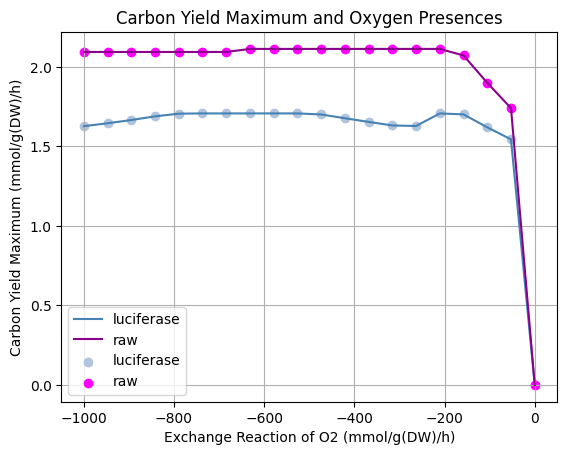

In [46]:
#get the changing O2 exchange flux and the maximum utilized carbon for the luciferase metabolic model 
x_l = prod_env['EX_cpd00007_e']
y_l = prod_env['carbon_yield_maximum']
flux_l = prod_env['flux_maximum']
#get the changing O2 exchange flux and the maximum utilized carbon for the raw metabolic model 
x_r = prod_env_raw['EX_cpd00007_e']
y_r = prod_env_raw['carbon_yield_maximum']
flux_r = prod_env_raw['flux_maximum']

#plot the data
plt.figure("Carbon Yield Maximum and Oxygen Presents", clear=True)
plt.plot(x_l, y_l, label='luciferase', color='steelblue')
plt.plot(x_r, y_r, label='raw', color='darkmagenta')
plt.scatter(x_l, y_l, label='luciferase', color='lightsteelblue')
plt.scatter(x_r, y_r, label='raw', color='magenta')
#annotate the model
plt.title("Carbon Yield Maximum and Oxygen Presences")
plt.xlabel("Exchange Reaction of O2 (mmol/g(DW)/h)")#plt.xlim(-100,0)
plt.ylabel('Carbon Yield Maximum (mmol/g(DW)/h)')
plt.grid()
plt.legend()

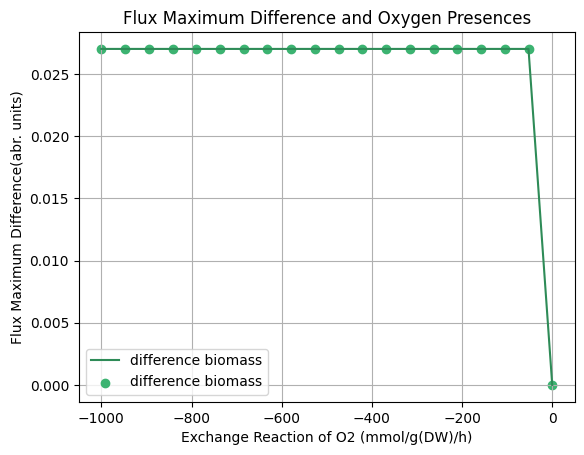

In [45]:
#plot the data for flux differences
plt.figure("Flux Maximum and Oxygen Presents", clear=True)
plt.plot(x_l, flux_l - flux_r, label='difference biomass', color='seagreen')
plt.scatter(x_l, flux_l - flux_r, label='difference biomass', color='mediumseagreen')

#annotate the model
plt.title("Flux Maximum Difference and Oxygen Presences")
plt.xlabel("Exchange Reaction of O2 (mmol/g(DW)/h)")
plt.ylabel('Flux Maximum Difference(abr. units)')
plt.grid()
plt.legend()